In [77]:
import tensorflow as tf
import functools
from tensorflow import feature_column
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

In [78]:
dataframe = pd.read_csv('lightpath_dataset.csv')
dataframe.drop(labels = ['class', 'snr', 'ber'], axis=1,inplace=True)
train, test = train_test_split(dataframe, test_size=0.2, shuffle=True)
#train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
#print(len(val), 'validation examples')
print(len(test), 'test examples')

845729 train examples
211433 test examples


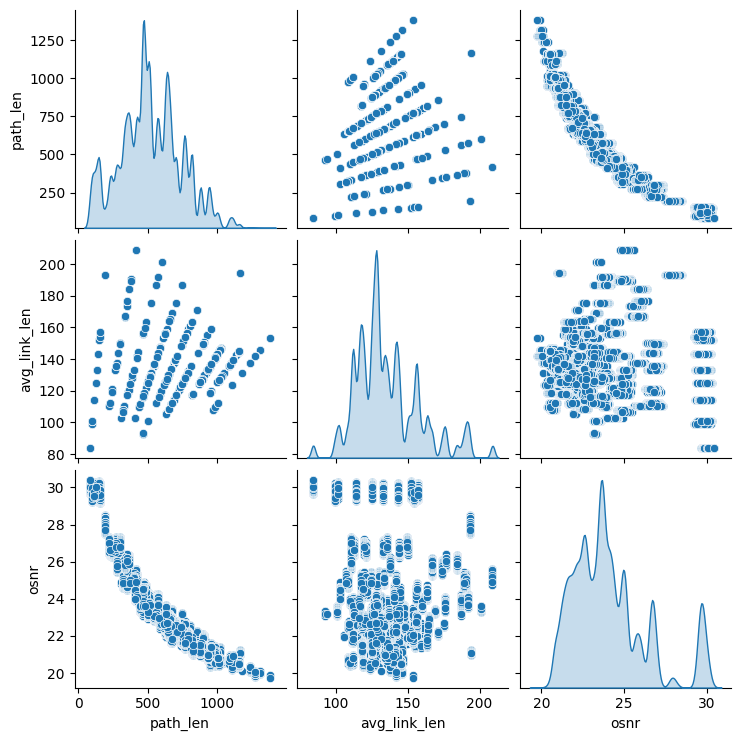

In [79]:
sns.pairplot(train[["path_len", "avg_link_len","osnr"]], diag_kind="kde")

In [80]:
train_labels = train.pop('osnr')
test_labels = test.pop('osnr')

In [81]:
train_stats = train.describe()
train_stats = train_stats.transpose()
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

In [82]:
def build_model():
  model = keras.Sequential([
    layers.Dense(96, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [84]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 96)                3456      
                                                                 
 dense_10 (Dense)            (None, 64)                6208      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [85]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

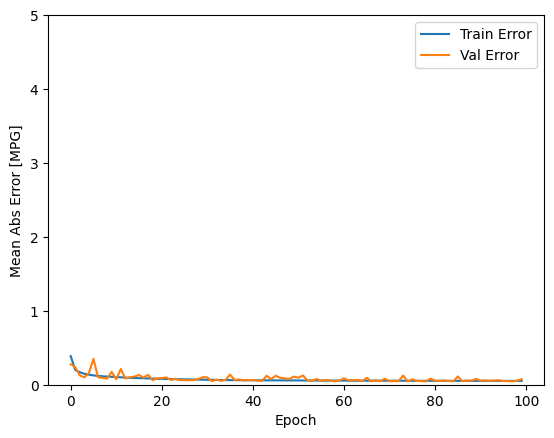

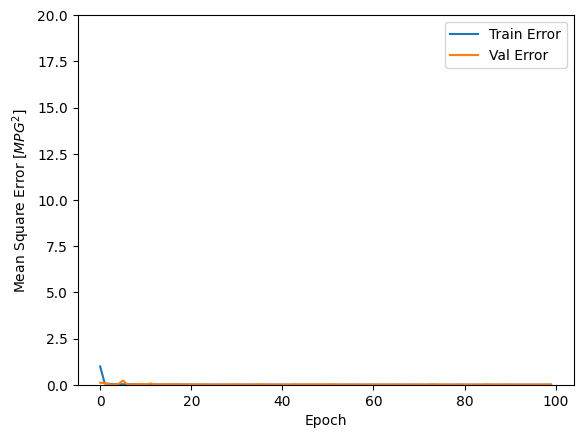

In [86]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [87]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

6608/6608 - 13s - loss: 0.0088 - mae: 0.0746 - mse: 0.0088 - 13s/epoch - 2ms/step
Testing set Mean Abs Error:  0.07 MPG


6608/6608 [==============================] - 8s 1ms/step


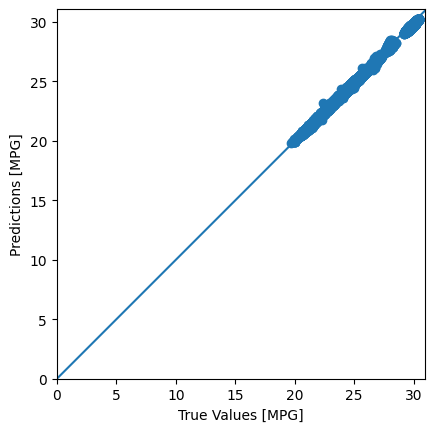

In [88]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

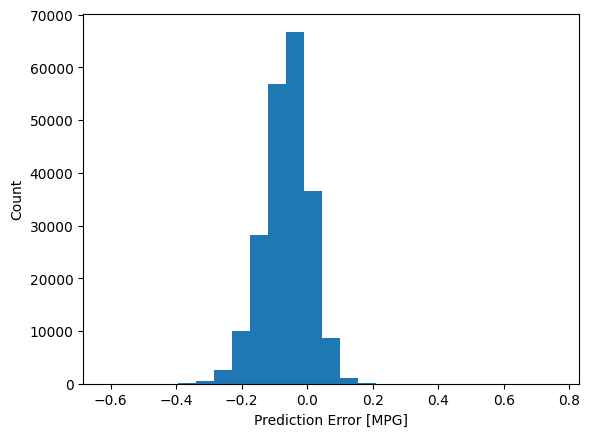

In [89]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")